In [2]:
!pip install mdptoolbox-hiive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import hiive.mdptoolbox.example
import time

  Created wheel for mdptoolbox-hiive: filename=mdptoolbox_hiive-4.0.3.1-cp37-none-any.whl size=35123 sha256=e28a948796bc6b51d8c36f43406e8f1348d36f7cf3f53e8b3c3dbd50eb1675d8
  Stored in directory: /root/.cache/pip/wheels/3a/98/1f/fc66dac0e97571e9c637565c74a78e8604f0a6457a0b6080d2
Successfully built mdptoolbox-hiive


In [3]:
seed = 7
ENV_DIM = 100
ENV_SIZE = ENV_DIM * ENV_DIM  # square board
ACTIONS = 4
MAX_MOVES = 1000
FROZN = '-'
HOLE = '0'
GOAL = 'G'
np.random.seed(seed)
pct_frozen = 0.9
env = [FROZN if np.random.random() < pct_frozen else HOLE for _ in range(ENV_SIZE)]
env[-1] = GOAL
print(' ' * 6 + f'Map {seed}')
def to_char(value):
    if value == HOLE:
        return '●'
    if value == GOAL:
        return '⨂'
    return value
for i in range(0, len(env), ENV_DIM):
    print(' '.join(map(to_char, env[i:i+ENV_DIM])))

      Map 7
- - - - ● - - - - - - - - - - ● - - ● - - ● - - ● - - - - - - - - - - - - - - - - - - - - - - ● - - - - - - - - - - - - ● - - - - - ● ● - - - - - - - - - - - - - - - - - - - - - - - ● - - - - - - - -
- - - - - - - - - - - - - - - ● - - - - - - - - - - - - ● - - - ● - - - - - - - - - - - - - - - - - - - - - - - - ● ● - - - ● - - - - - - - - - ● - - - - - - - - - - - - - - - ● - - - - - - - ● - - -
- - - ● - - - - - - ● ● - - - ● - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ● - - - - - - - - - - - - ● - - - - - - - ● - - ● - - - - - - - - - ● - - - - -
● - - ● - - - - - - - - - - - - - - - - - - - - - - - - ● - - - - - - - - - - - ● - - - - - ● - - - - - - - - - - - - - - - - - ● - - - - - - - - - - - - ● - - - - - ● - - - - ● - - - - - - ● - - - -
- - - - ● - - - - - - - ● ● - - - - - - - ● ● ● ● ● - ● - - - ● - - - ● - - - - - - - - ● - - - - - - - - - - - - - - - - - ● - - - - - - - - - - - - - - - - - ● - - - ● - - - - - - - - - 

In [4]:
target_prob = 0.7
slip_prob = 0.15
assert target_prob + slip_prob + slip_prob == 1

def move(direction, from_state):
    if direction == 0:
        if from_state < ENV_DIM or env[from_state] == HOLE:
            return from_state
        else:
            return from_state - ENV_DIM
    if direction == 1:
        if from_state % ENV_DIM == ENV_DIM - 1 or env[from_state] == HOLE:
            return from_state
        else:
            return from_state + 1
    if direction == 2:
        if from_state // ENV_DIM == ENV_DIM - 1 or env[from_state] == HOLE:
            return from_state
        else:
            return from_state + ENV_DIM
    if direction == 3:
        if from_state % ENV_DIM == 0 or env[from_state] == HOLE:
            return from_state
        else:
            return from_state - 1
    raise Exception(f'Unknown direction: {direction}')

    
def calc_s_prime(a, s):
    result = [0] * ENV_SIZE
    
    intended = move(a, s)
    result[intended] += target_prob
    
    slip_left = move((a - 1) % ACTIONS, s)
    result[slip_left] += slip_prob
    
    slip_right = move((a + 1) % ACTIONS, s)
    result[slip_right] += slip_prob
    
    assert sum(result) == 1
    return result
transitions = np.array([
    [calc_s_prime(a, s) for s in range(ENV_SIZE)]
    for a in range(ACTIONS)
])

def generate_rewards(frozen_reward, hole_reward, goal_reward):
    return np.array([hole_reward if env[i] == HOLE else goal_reward if env[i] == GOAL else frozen_reward
                     for i in range(len(env))])

In [5]:
valid_starts = [i for i in range(ENV_SIZE) if env[i] == FROZN]

def calc_avg_reward(policy, rewards, iterations=100):
    total_rewards = 0
    for start in np.random.choice(valid_starts, iterations):
        total_rewards += get_reward(policy, rewards, start)
    return total_rewards / iterations

def get_reward(policy, rewards, start, verbose=False):
    reward = 0
    curr = start
    move = 0
    while env[curr] == FROZN and move < MAX_MOVES:
        move += 1
        reward += rewards[curr]
        a = policy[curr]
        if verbose:
            print(f'{move} curr {curr} ({env[curr]}) then {symbols[a]} ')
        probs = transitions[a][curr]
        curr = np.random.choice(range(len(probs)), p=probs)
    reward += rewards[curr]
    return reward
symbols = ('↑', '→', '↓', '←')
def to_symbol(x, i):
    if env[i] == HOLE:
        return '●'
    if env[i] == GOAL:
        return '⨂'
    return symbols[x]

def print_policy(policy):
    for i in range(0, len(env), ENV_DIM):
        print(' '.join(to_symbol(policy[i+j], i+j) for j in range(ENV_DIM)))

In [6]:
results_columns = ['iterations', 'avg_reward', 'seconds_elapsed']

def run_mdp(MDP, transitions, rewards, discount, step, verbose=False):
    np.random.seed(seed)
    results = pd.DataFrame(columns=results_columns, dtype=float)
    iters = step
    while True:
        mdp = MDP(transitions, rewards, discount)
        mdp.max_iter = iters
        mdp.run()
        
        policy = mdp.policy
        actual_iters = mdp.iter
        avg_reward = calc_avg_reward(policy, rewards, 500)
        
        results.loc[actual_iters, results_columns] = (actual_iters, avg_reward, mdp.time)
        if verbose:
            print({'iterations': mdp.iter, 'seconds elapsed': mdp.time, 'avg reward': avg_reward})
        
        if actual_iters < iters:
            # we have converged!
            break
        iters += step
    return policy, results

def print_mismatches(p0, p1):
    assert len(p0) == len(p1)
    mismatches = [(i, p0[i], p1[i])
                  for i in range(len(p0))
                  if p0[i] != p1[i] and env[i] != GOAL]
    for i, v, p in mismatches:
            print(f"mismatch at {i} (row {i // ENV_DIM}, col {i % ENV_DIM})")
            print(f"  p0 gave {to_symbol(v, i)} and p1 gave {to_symbol(p, i)}")
standard_rewards = generate_rewards(-0.04, -1, 1)
discount = 0.96
max_iter = 50000

In [7]:
vi = ValueIteration(transitions, standard_rewards, discount)
vi.setVerbose()
arr_vi = vi.run()
print("Value iteration")
print_policy(vi.policy)

 Iteration   Variation
         1    2.000000
         2    1.770240
         3    1.677865
         4    1.593153
         5    1.524806
         6    1.459743
         7    1.400031
         8    1.342839
         9    1.288695
        10    1.236757
        11    1.187136
        12    1.139513
        13    1.093877
        14    1.050071
        15    1.008047
        16    0.967706
        17    0.928989
        18    0.891822
        19    0.856146
        20    0.821897
        21    0.789020
        22    0.757458
        23    0.727159
        24    0.698072
        25    0.670149
        26    0.643343
        27    0.617609
        28    0.592905
        29    0.569188
        30    0.546421
        31    0.524564
        32    0.503581
        33    0.483438
        34    0.464101
        35    0.445537
        36    0.427715
        37    0.410607
        38    0.394182
        39    0.378415
        40    0.363278
        41    0.348747
        42    0.334797
        43 

In [8]:
pi = PolicyIteration(transitions, standard_rewards, discount, max_iter=max_iter)
pi.setVerbose()
arr_pi = pi.run()
print("Policy Iteration")
print_policy(pi.policy)

 Iteration   Variation
         1        7994
         2        4943
         3        3408
         4        2678
         5        2138
         6        1788
         7        1697
         8        1664
         9        1619
        10        1264
        11         823
        12         512
        13         278
        14         141
        15          84
        16          53
        17          26
        18          18
        19          10
        20           9
        21           3
        22           1
        23           0
Iterating stopped, unchanging policy found.
Policy Iteration
↓ ↓ ← ← ● → ↓ ↓ ↓ ← ← ← ← ← ← ● → ← ● → ← ● → ← ● → ↑ ↑ ↑ → ↓ ↓ ↑ → ↓ → → → → → → → → → → ↓ ← ● → → → → → → ↓ ↓ ← ↑ ↑ ← ● → ↑ → → ← ● ● → ↓ ↓ ← ↑ ↑ → ↓ ↓ ← ← ← ← ← ← → → ↓ ↓ ← ↑ ↓ ← ● → ↓ ↑ ↑ ↑ ↑ ← ←
→ ↓ ← ↑ ↓ → ↓ ↓ ↓ ← ↑ ↑ ↑ ↑ ← ● → → ↓ → ← ↓ ← ← ↓ ↑ ↑ ← ● → ↓ ← ● → ↓ → → → → → → → → → → → → ↓ → → → → → → ↓ ↓ ← ● ● ↓ ← ↓ ● → → → ↓ ↓ ↓ ↓ ↓ ← ● → → ↓ ↓ ← ← ← ↑ ↑ ↑ ↑ ↑ → ↓ ← ● → ↓ ↓ ↓ ←

In [9]:
np.random.seed(0)
ql = QLearning(transitions, standard_rewards, discount, n_iter=max_iter)
ql.setVerbose()
arr_ql = ql.run()
print("QLearning")
print (arr_ql[-1])
print_policy(ql.policy)

QLearning
{'State': 1217, 'Action': 1, 'Reward': -0.04, 'Error': 4e-05, 'Time': 180.07079124450684, 'Alpha': 0.001, 'Epsilon': 0.1, 'Gamma': 0.96, 'Max V': 0.00797473431026701, 'Mean V': -0.0012512491026003731, 'Iteration': 50000}
↑ ↑ ↑ ← ● ↓ ← → ↓ → ↑ ↑ ↑ ↑ ↑ ● ↑ ↑ ● ↑ → ● ↑ ↑ ● ↑ ↑ ↑ ↑ ↑ ↓ ← ← ← ↑ ← ↑ ← ↑ ← ↓ ↓ ← ↓ ↑ ← ↓ ● → ↑ ↓ ← ↓ ← ← ↓ ← ↑ ← ↑ ● → ↓ ↓ → ↑ ● ● ↑ ↑ → ↑ ← ↑ ← ← ↑ ↑ ↑ ↑ ← ← ← ← → ← ↓ → ↑ → ↑ ● → ↑ ↑ ↓ ↓ ↓ ← ↑
↑ ↑ ↑ → ↓ ← ← ↓ ← ← ↓ → → ← ← ● ↑ ↑ ↑ ↑ → ↑ ↑ ↑ ↑ ↑ ↑ ↑ ● ↓ → ↓ ● ↑ ↑ ↑ ← → ← → ↑ ↑ ← ← → ← → → ↓ ↑ → → ↓ → ← → → ● ● ↓ ↑ ↓ ● → ↑ ↑ ↑ ← ↑ ↑ ← → ● ← ↑ → ↑ ↑ → ← ↓ ↓ ↑ ↓ ← ← → ↑ ● ↑ ↑ → ↑ → ↑ ↑ ● → ↑ ↑
↑ ↑ ↑ ● ↑ ↓ ↓ → ← ↑ ● ● ↑ ← ↓ ● ↑ ↑ ↑ ↑ → ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → → ↓ ↓ ← ↓ ↓ ← ↑ ↑ → ↑ ↑ ↓ ↓ ← ← → → ↓ → → ↑ ↑ ← ↑ ↓ ← → → → ● ↑ ↑ ↑ ↑ ↑ ↑ ← ↓ → ↑ ↑ ↑ ● → → → ↑ ↑ ↑ → ● ↓ → ● ↓ → ↓ ↑ ↑ ↑ → ↑ → ● ↑ → ← ↑ ↑
● ↑ ↑ ● ↑ ↑ ← → ← → → → ↑ → ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ● ↑ ↓ → ↓ ↑ ↓ → ↑ ↓ → → ● → → ↑ → → ● ↑ → ↑ ↑ ↑ ↑ ↓ ↓ ← ↑ ↑ ↓ → ↑ ↑ ↑ ↑ ● ↑ → → ↓ ↓ ↑ ↑ ↑ ↑ → → → ● ← → → ↑ ↑ ● ↑

In [10]:
print ("VI policy is the same as PI policy: ", vi.policy==pi.policy)
print ("VI policy is the same as QL policy: ", ql.policy==vi.policy)
print ("QL policy is the same as PI policy: ", ql.policy==pi.policy)

VI policy is the same as PI policy:  False
VI policy is the same as QL policy:  False
QL policy is the same as PI policy:  False


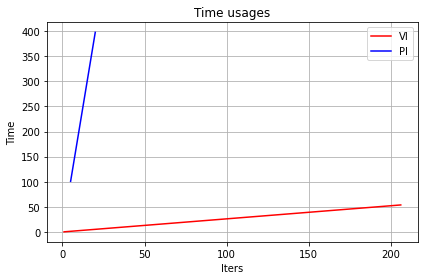

(None, None)

In [11]:
time_vi = []
iter_vi = []
for x in arr_vi:
  time_vi.append(x['Time'])
  iter_vi.append(x['Iteration'])
time_pi = []
iter_pi = []
for x in arr_pi:
  time_pi.append(x['Time'])
  iter_pi.append(x['Iteration'])
plt.grid()
plt.plot(iter_vi, time_vi, color='red', label='VI')
plt.plot(iter_pi, time_pi, color='blue', label='PI')
plt.xlabel('Iters'), plt.ylabel('Time'), plt.legend(loc='best'), plt.title('Time usages')
plt.tight_layout(), plt.show()

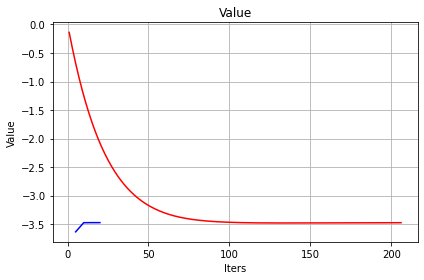

(None, None)

In [12]:
value_vi = []
value_pi = []
for x in arr_vi:
  value_vi.append(x['Mean V'])
for x in arr_pi:
  value_pi.append(x['Mean V'])
plt.grid()
plt.plot(iter_vi, value_vi, color='red', label='VI')
plt.plot(iter_pi, value_pi, color='blue', label='PI')
plt.xlabel('Iters'), plt.ylabel('Value'), plt.title('Value')
plt.tight_layout(), plt.show()

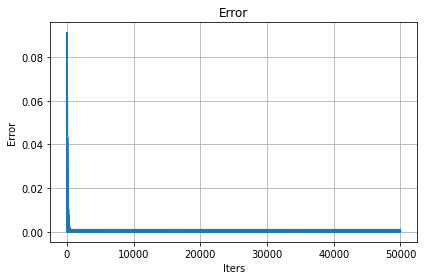

(None, None)

In [13]:
reward = np.zeros(max_iter)
error = np.zeros(max_iter)
iteration = np.arange(1, max_iter+1)
for x in arr_ql:
  for i in range(1, max_iter+1):
    if x['Iteration'] == i:
      error[i-1] = error[i-1]+abs(x['Error'])
      reward[i-1] = reward[i-1]+(x['Reward'])
y = []
y.append(error[0])
for i in range (1, max_iter):
  y.append(abs(error[i]-error[i-1]))
plt.grid()
plt.plot(iteration, y)
plt.xlabel("Iters"), plt.ylabel('Error'), plt.title('Error')
plt.tight_layout(), plt.show()

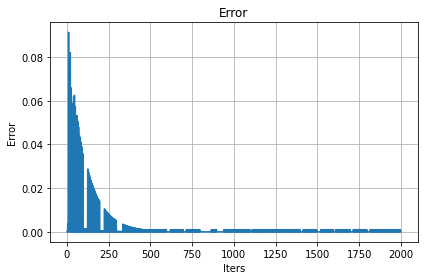

(None, None)

In [14]:
plt.grid()
plt.plot(iteration[:2000], y[:2000])
plt.xlabel("Iters"), plt.ylabel('Error'), plt.title('Error')
plt.tight_layout(), plt.show()

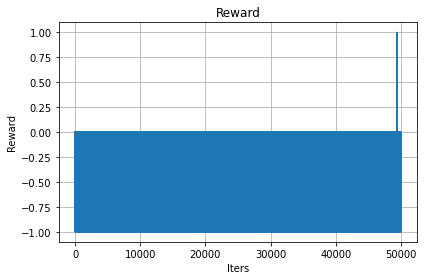

(None, None)

In [15]:
plt.grid()
plt.plot(iteration, reward)
plt.xlabel("Iters"), plt.ylabel('Reward'), plt.title('Reward')
plt.tight_layout(), plt.show()